In [164]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

np.random.seed(163)

%run "DiffKf.ipynb"
%run "KF.ipynb"

In [165]:
dt = 10

C = np.array([[0.34,0.33, 0, 0, 0.33],[0.33,0.34,0.33,0,0],[0,0.33,0.34,0.33,0],[0,0,0.33,0.34,0.33],[0.33,0,0,0.33,0.34]])
num_stns = len(C[0])

A = np.array([[1, dt, 0, 0], [0, 1, 0, 0],[0,0,1,dt], [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 0],[0,0,1,0]])

dkf_state_size = len(A)
dkf_measure_size = len(H)

q = 0.001
Q = q*np.array([[(dt**3)/3, (dt**2)/2, 0, 0], [(dt**2)/2, dt, 0, 0],[0,0,(dt**3)/3,(dt**2)/2], [0, 0, (dt**2)/2, dt]])
R = np.array([[4,0],[0,4]])

A_kf = np.kron(np.eye(num_stns),A)
H_kf = np.kron(np.eye(num_stns),H)
Q_kf = np.kron(np.eye(num_stns),Q)
R_kf = np.kron(np.eye(num_stns),R)

kf_state_size = A_kf.shape[0]
kf_measure_size = R_kf.shape[0]

F = [A for _ in range(num_stns)]
G = [np.eye(dkf_state_size) for _ in range(num_stns)]
H_dkf = [H for _ in range(num_stns)]

Q_dkf = [Q for _ in range(num_stns)]
R_dkf = [R for _ in range(num_stns)]

In [166]:
procc_noise_kf = lambda : np.linalg.cholesky(Q_kf) @ np.random.normal(np.array([[0 for _ in range(kf_state_size)]]).T)
measure_noise_kf = lambda : np.linalg.cholesky(R_kf) @ np.random.normal(np.array([[0 for _ in range(kf_measure_size)]]).T)

measure_kf_to_dkf  = lambda z: [np.array([z[dkf_measure_size*i + j] for j in range(dkf_measure_size)]) for i in range(num_stns)]
state_kf_to_dkf = lambda z: [np.array([z[dkf_state_size*i + j] for j in range(dkf_state_size)]) for i in range(num_stns)]

In [167]:
#True Initial
x0_kf = np.array([[np.random.normal(0,np.sqrt(Q_kf[i,i])) for i in range(kf_state_size)]]).T


#Initial Estimate
x_kf = np.array([[np.random.normal(0,5) for i in range(kf_state_size)]]).T
x_dkf = state_kf_to_dkf(x_kf)


P_kf = 10*np.copy(Q_kf)
P_dkf = [10*np.copy(Q) for _ in range(num_stns)]

kf = KalmanFilter(A = A_kf,H = H_kf, Q = Q_kf, R = R_kf,P=P_kf,x0=x_kf)

dkf = DiffKF(C,F,G,H_dkf,R_dkf,Q_dkf,x_dkf,P_dkf)

In [168]:

iters = 60

convergence_bound = 0.00001

truth = np.zeros((iters+1,kf_state_size,1))
truth[0] = x0_kf

measurements = np.zeros((iters+1,kf_measure_size,1))
measurements[0] = (H_kf @ x0_kf)+measure_noise_kf()


predictions_kf = np.zeros((iters,kf_state_size,1))
predictions_dkf = np.zeros((iters,num_stns,dkf_state_size,1))

errors_kf = np.zeros((iters,kf_state_size,1))
errors_dkf = np.zeros((iters,num_stns,dkf_state_size,1))

P_hist_kf = np.zeros((iters,kf_state_size,kf_state_size))
P_hist_dkf = np.zeros((iters, num_stns, dkf_state_size,dkf_state_size))

for i in range(iters):

    kf.update(measurements[i])
    dkf.update(measure_kf_to_dkf(measurements[i]))

    predictions_dkf[i] = [dkf.nodes[j].x for j in range(num_stns)]
    errors_dkf[i] = [dkf.nodes[j].x-state_kf_to_dkf(truth[i])[j] for j in range(num_stns)]
    P_hist_dkf[i] = [dkf.nodes[j].P for j in range(num_stns)]

    predictions_kf[i] = kf.x
    errors_kf[i] = kf.x-truth[i]
    P_hist_kf[i] = kf.P

    if i >= 1:
        change_kf = np.linalg.norm(kf.P - P_hist_kf[i-1])
        if change_kf < convergence_bound:
            iters = i+1
            break
        # change_dkf = np.linalg.norm(dkf.P - P_hist_dkf[i-1])

    kf.predict()
    dkf.predict()

    truth[i+1] = A_kf@x0_kf + procc_noise_kf()
    measurements[i+1] = H_kf @ truth[i+1] + measure_noise_kf()

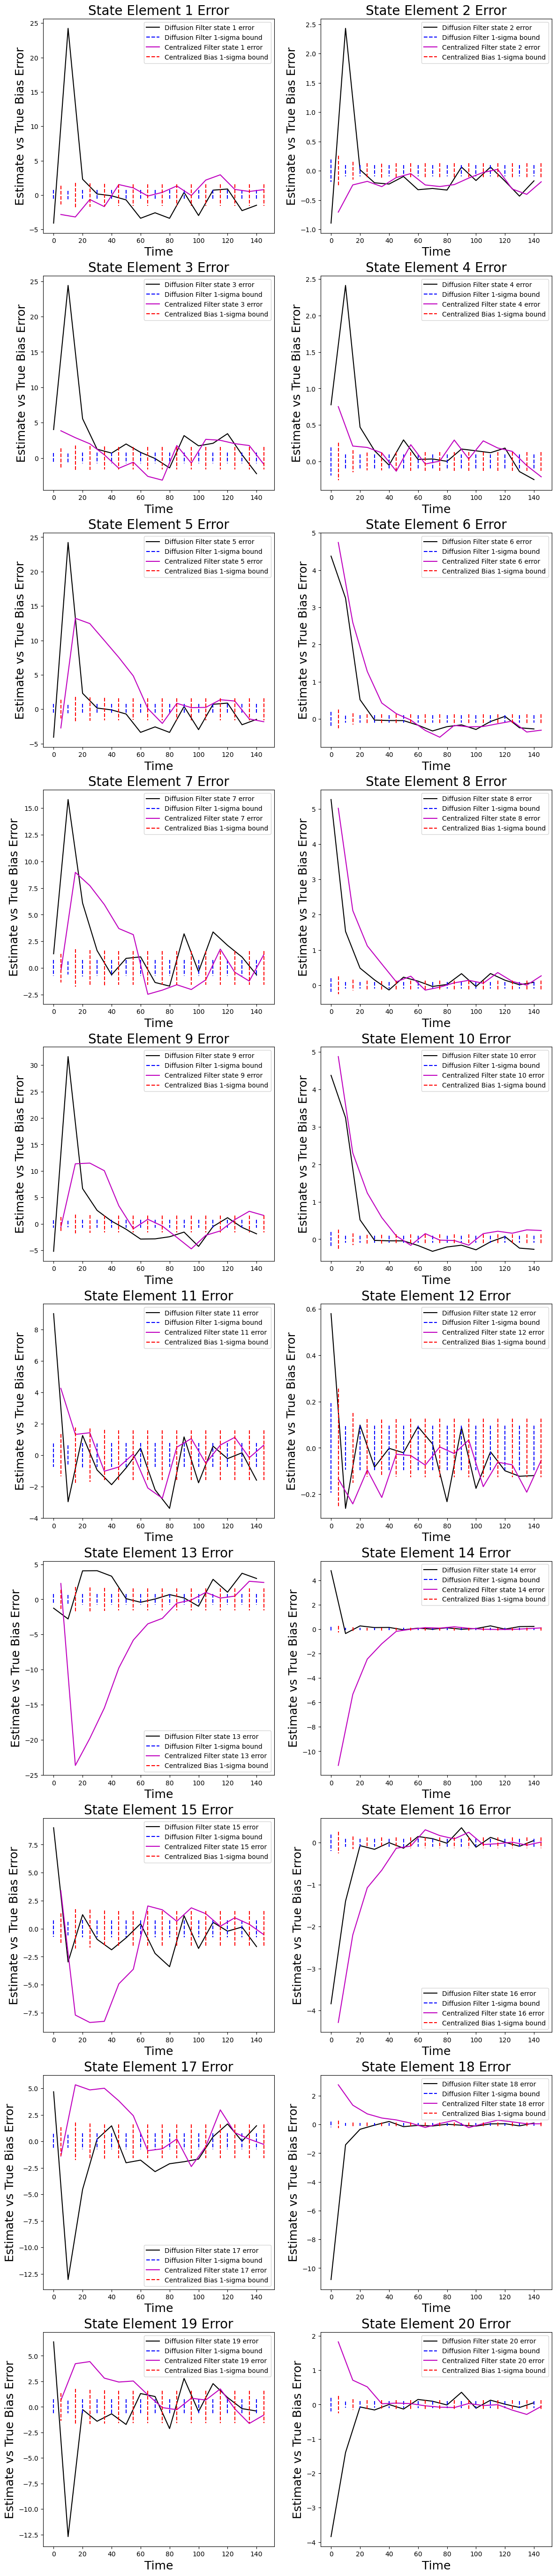

In [169]:
num_rows = -1*((-1*kf_state_size)//2)
fig,axs = plt.subplots(num_rows,2, figsize=(14, 7*num_rows))
t_hist_dkf = np.arange(0, dt*iters, dt)
t_hist_kf = np.arange(dt/2, dt*iters, dt)

for i in range(kf_state_size):
    axs[i//2][i%2].plot(t_hist_dkf, errors_dkf[:iters, i//num_stns,i%dkf_state_size,0], 'k', label = f"Diffusion Filter state {i+1} error")
    dkf_cov = np.sqrt(P_hist_dkf[:iters, i//num_stns,i%dkf_state_size,i%dkf_state_size])
    axs[i//2][i%2].plot(np.vstack([t_hist_dkf[0], t_hist_dkf[0]]), np.vstack([dkf_cov[0], -dkf_cov[0]]), 'b--', label = "Diffusion Filter 1-sigma bound")
    axs[i//2][i%2].plot(np.vstack([t_hist_dkf[1:iters], t_hist_dkf[1:iters]]), np.vstack([dkf_cov[1:], -dkf_cov[1:]]), 'b--')
    kf_error = errors_kf[:iters, i,0]
    kf_cov = np.sqrt(P_hist_kf[:iters, i, i])
    axs[i//2][i%2].plot(t_hist_kf, kf_error,'m',label=f'Centralized Filter state {i+1} error')
    axs[i//2][i%2].plot(np.vstack([t_hist_kf[0], t_hist_kf[0]]), np.vstack([kf_cov[0], -kf_cov[0]]), 'r--',label = "Centralized Bias 1-sigma bound")
    axs[i//2][i%2].plot(np.vstack([t_hist_kf[1:], t_hist_kf[1:]]), np.vstack([kf_cov[1:], -kf_cov[1:]]), 'r--')
    axs[i//2][i%2].legend()
    axs[i//2][i%2].set_title("State Element "+str(i+1)+" Error", fontsize = 20)
    axs[i//2][i%2].set_xlabel("Time", fontsize = 18)
    axs[i//2][i%2].set_ylabel("Estimate vs True Bias Error", fontsize = 18)